# Binary Classification Approach

In [245]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score,f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns


In [246]:
df = pd.read_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')
df = df[(df['winner'] == df['team1']) | (df['winner'] == df['team2'])]
df['target_binary'] = (df['winner'] == df['team1']).astype(int)

X = df[['season', 'city', 'venue', 'toss_winner', 'toss_decision', 'team1', 'team2',
        'inning1_runs', 'inning1_wickets', 'inning1_balls']]
X = pd.get_dummies(X)
y = df['target_binary']

In [247]:
#Trainig the model in different test sizes

test_sizes = [0.1, 0.2, 0.3, 0.4]
split_results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size: {test_size:.2f}, Accuracy: {acc * 100:.2f}%")
    split_results.append((test_size, acc))


Test size: 0.10, Accuracy: 59.09%
Test size: 0.20, Accuracy: 62.50%
Test size: 0.30, Accuracy: 56.82%
Test size: 0.40, Accuracy: 57.67%


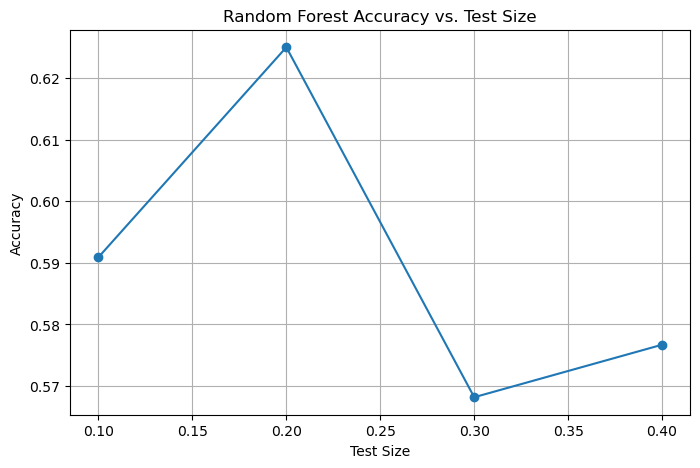

In [248]:
#Plot accuracy vs test sizes
split_results_df = pd.DataFrame(split_results, columns=["Test Size", "Accuracy"])
plt.figure(figsize=(8,5))
plt.plot(split_results_df["Test Size"], split_results_df["Accuracy"], marker='o')
plt.title("Random Forest Accuracy vs. Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [249]:
#Plotting the Confusion Matrix for the best test size
chosen_test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=chosen_test_size, stratify=y, random_state=42
)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

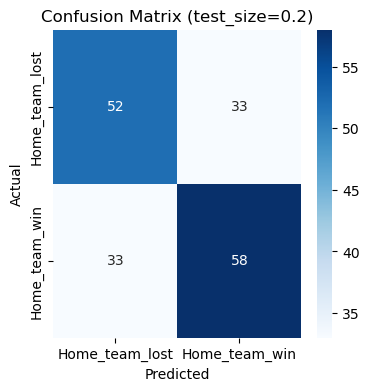

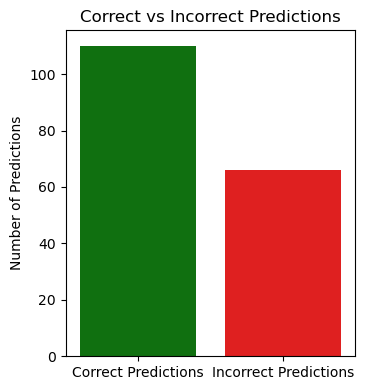

In [250]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home_team_lost', 'Home_team_win'], yticklabels=['Home_team_lost', 'Home_team_win'])
plt.title(f"Confusion Matrix (test_size={chosen_test_size})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Correct vs Incorrect Predictions
tn, fp, fn, tp = cm.ravel()
correct = tp + tn
incorrect = fp + fn
# Plot bar chart
plt.figure(figsize=(3.75, 4))
sns.barplot(x=["Correct Predictions", "Incorrect Predictions"], y=[correct, incorrect], palette=["green", "red"])
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Number of Predictions")
plt.tight_layout()
plt.show()


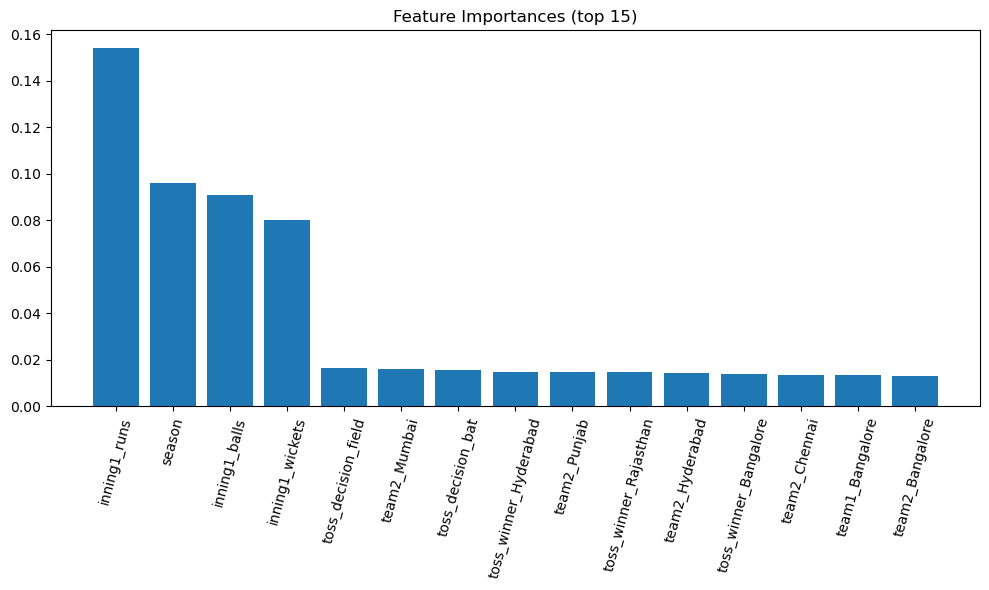

In [251]:
# 3. Feature importance
importances = rf.feature_importances_
indices = importances.argsort()[::-1]
feature_names = X.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importances (top 15)")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=75)
plt.tight_layout()
plt.show()


                precision  recall  f1-score  support
Home_team_lost      0.612   0.612     0.612   85.000
Home_team_win       0.637   0.637     0.637   91.000
accuracy            0.625   0.625     0.625    0.625
macro avg           0.625   0.625     0.625  176.000
weighted avg        0.625   0.625     0.625  176.000


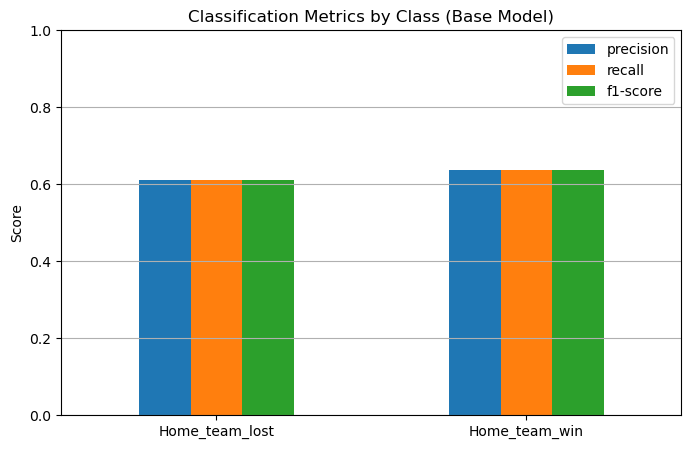

In [252]:
#Classification report
report = classification_report(y_test, y_pred, target_names=['Home_team_lost', 'Home_team_win'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(3)
# Show as table
print(report_df)
report_df

plot_df = report_df.loc[['Home_team_lost', 'Home_team_win'], ['precision', 'recall', 'f1-score']]
plot_df.plot(kind='bar', figsize=(8, 5))
plt.title('Classification Metrics by Class (Base Model)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()



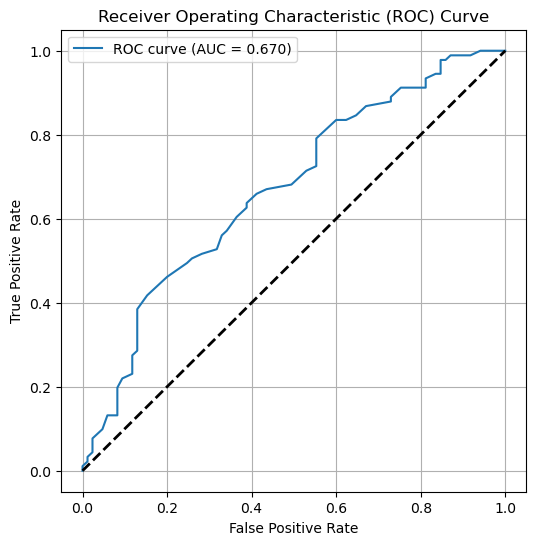

In [253]:
# Probabilities for the positive class (team1_win, which is 1)
y_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.show()

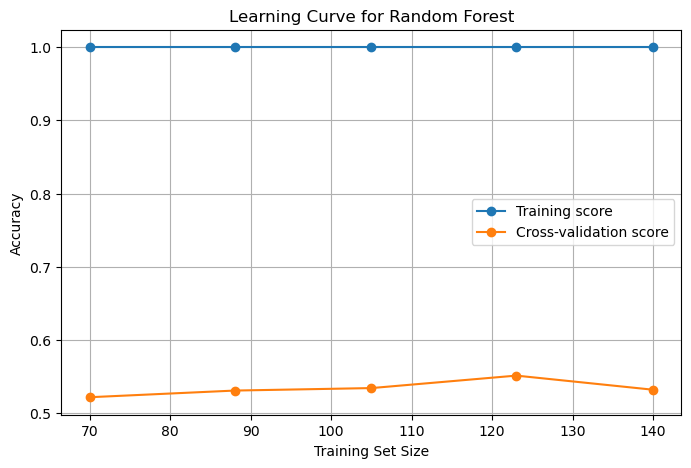

In [254]:
#Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42),
    X, y,
    train_sizes=np.linspace(0.1, 0.2, 5),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()


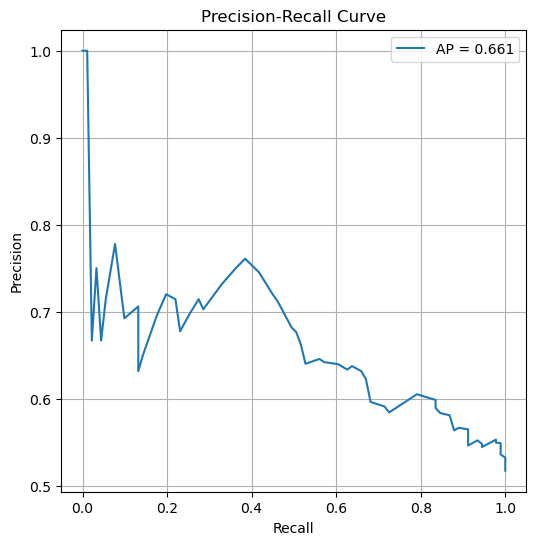

In [255]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

In [256]:
test_sizes = [0.2]
split_results = []

# Define a small parameter grid for quick search (expand for serious tuning!)
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Baseline model
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size: {test_size:.2f}, Baseline Accuracy: {acc:.4f}")

    # Hyperparameter tuning
    grid = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        cv=5,           
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    y_pred_tuned = grid.predict(X_test)
    acc_tuned = accuracy_score(y_test, y_pred_tuned)
    print(f"Test size: {test_size:.2f}, Tuned Accuracy: {acc_tuned:.4f}, Best Params: {grid.best_params_}")

    split_results.append((test_size, acc, acc_tuned, grid.best_params_))


Test size: 0.20, Baseline Accuracy: 0.6250
Test size: 0.20, Tuned Accuracy: 0.6136, Best Params: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


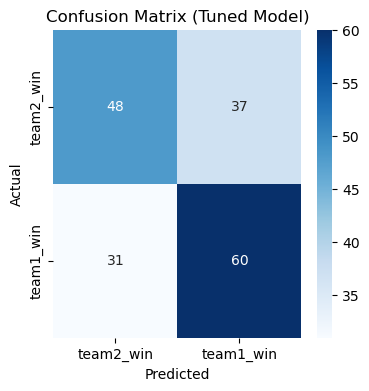

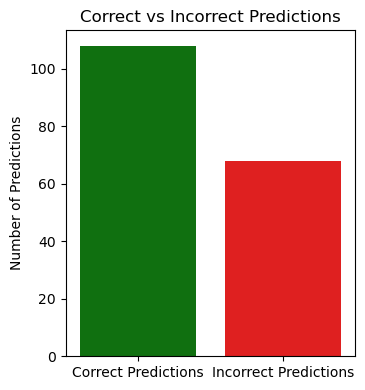

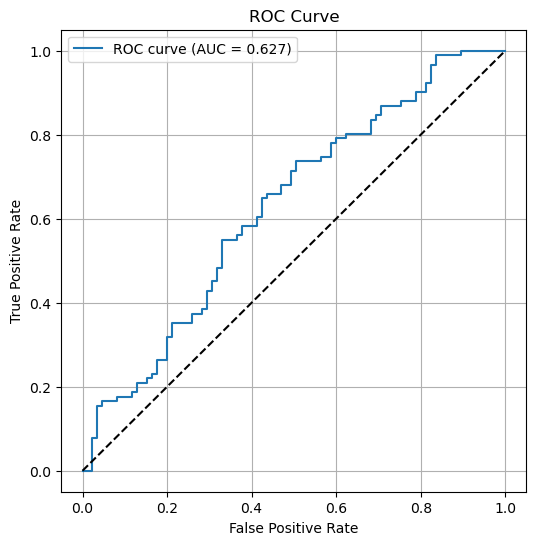

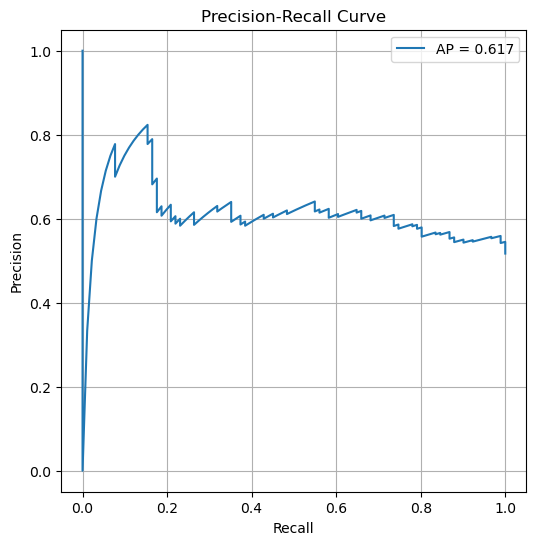

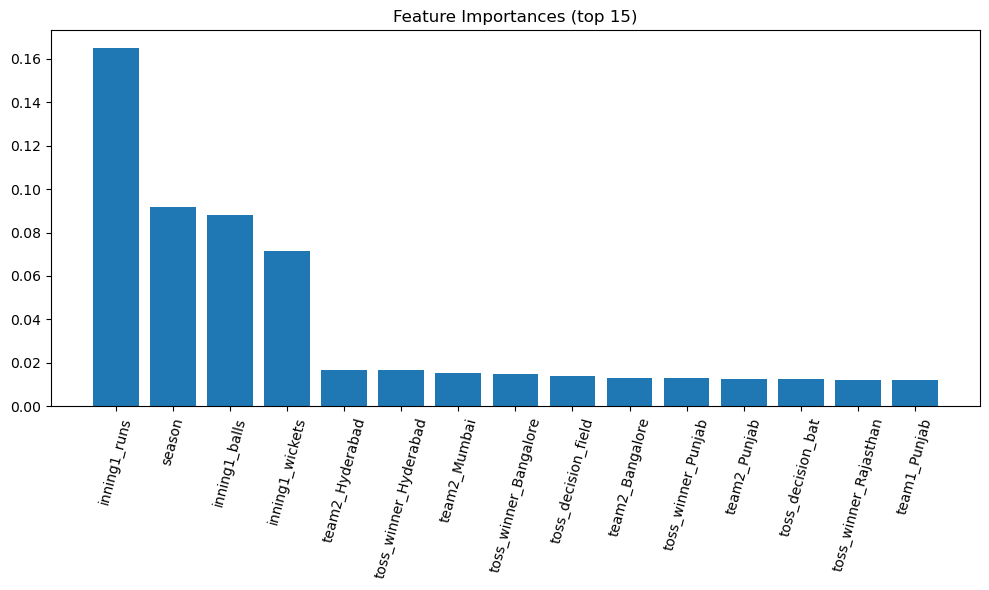

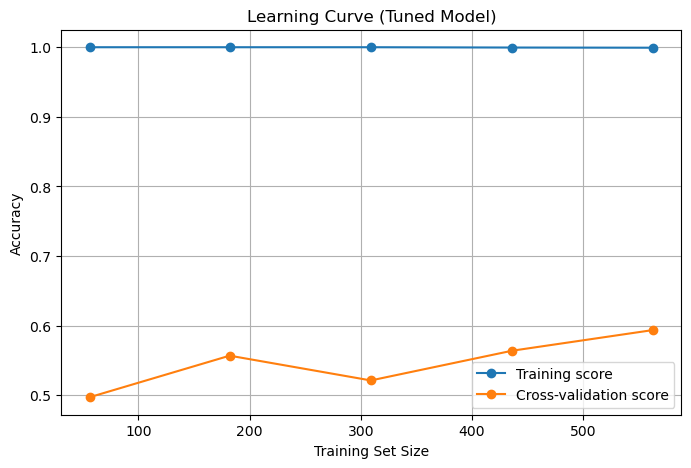

,precision,recall,f1-score,support
team2_win,0.608,0.565,0.585,85.000
team1_win,0.619,0.659,0.638,91.000
accuracy,0.614,0.614,0.614,0.614
macro avg,0.613,0.612,0.612,176.000
weighted avg,0.613,0.614,0.613,176.000


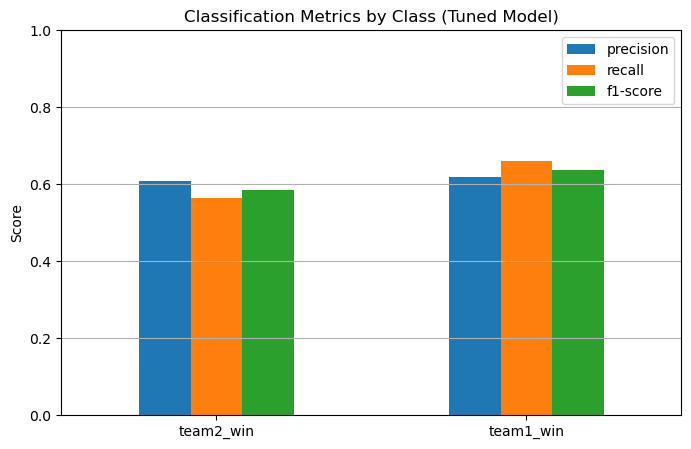

In [257]:
# 1. Get best model from GridSearchCV
best_rf = grid.best_estimator_
print(f"Best parameters: {grid.best_params_}")
# 2. Predict on test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['team2_win', 'team1_win'], 
            yticklabels=['team2_win', 'team1_win'])
plt.title("Confusion Matrix (Tuned Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


tn, fp, fn, tp = cm.ravel()
correct = tp + tn
incorrect = fp + fn
# Plot bar chart
plt.figure(figsize=(3.75, 4))
sns.barplot(x=["Correct Predictions", "Incorrect Predictions"], y=[correct, incorrect], palette=["green", "red"])
plt.title("Correct vs Incorrect Predictions")
plt.ylabel("Number of Predictions")
plt.tight_layout()
plt.show()

# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 5. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# 6. Feature Importance
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_test.columns

plt.figure(figsize=(10,6))
plt.title("Feature Importances (top 15)")
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), [feature_names[i] for i in indices[:15]], rotation=75)
plt.tight_layout()
plt.show()

# 7. Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=5, scoring='accuracy', n_jobs=-1, shuffle=True, random_state=42
)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label="Training score")
plt.plot(train_sizes, test_scores.mean(axis=1), 'o-', label="Cross-validation score")
plt.title("Learning Curve (Tuned Model)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 8. Classification Report as DataFrame
report = classification_report(y_test, y_pred, target_names=['team2_win', 'team1_win'], output_dict=True)
report_df = pd.DataFrame(report).transpose().round(3)
display(report_df)  # or print(report_df) if not in Jupyter

# 9. Bar Plot of classification metrics
plot_df = report_df.loc[['team2_win', 'team1_win'], ['precision', 'recall', 'f1-score']]
plot_df.plot(kind='bar', figsize=(8, 5))
plt.title('Classification Metrics by Class (Tuned Model)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


=== Base Model Metrics ===
Accuracy: 0.625
ROC AUC: 0.6699418228829993
              precision    recall  f1-score   support

   team2_win       0.61      0.61      0.61        85
   team1_win       0.64      0.64      0.64        91

    accuracy                           0.62       176
   macro avg       0.62      0.62      0.62       176
weighted avg       0.62      0.62      0.62       176


=== Tuned Model Metrics ===
Accuracy: 0.6136363636363636
ROC AUC: 0.6270200387847447
              precision    recall  f1-score   support

   team2_win       0.61      0.56      0.59        85
   team1_win       0.62      0.66      0.64        91

    accuracy                           0.61       176
   macro avg       0.61      0.61      0.61       176
weighted avg       0.61      0.61      0.61       176



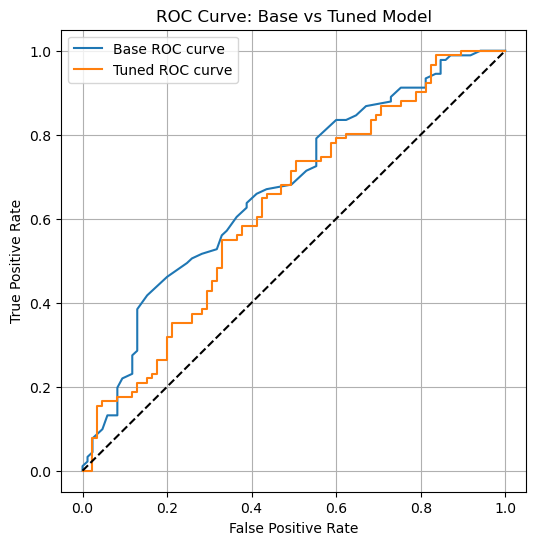

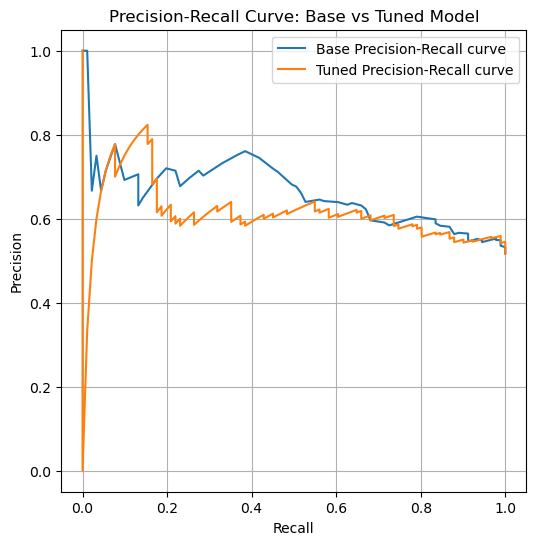

In [258]:
# 1. Fit base model (default hyperparameters)
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_train, y_train)
y_pred_base = base_rf.predict(X_test)
y_proba_base = base_rf.predict_proba(X_test)[:, 1]

# 2. Get tuned model predictions
tuned_rf = grid.best_estimator_
y_pred_tuned = tuned_rf.predict(X_test)
y_proba_tuned = tuned_rf.predict_proba(X_test)[:, 1]

# 3. Print main metrics
print("=== Base Model Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("ROC AUC:", roc_auc_score(y_test, y_proba_base))
print(classification_report(y_test, y_pred_base, target_names=['team2_win', 'team1_win']))

print("\n=== Tuned Model Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("ROC AUC:", roc_auc_score(y_test, y_proba_tuned))
print(classification_report(y_test, y_pred_tuned, target_names=['team2_win', 'team1_win']))

# 4. Plot ROC curves together
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_base, tpr_base, _ = roc_curve(y_test, y_proba_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_proba_tuned)

plt.figure(figsize=(6,6))
plt.plot(fpr_base, tpr_base, label='Base ROC curve')
plt.plot(fpr_tuned, tpr_tuned, label='Tuned ROC curve')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Base vs Tuned Model")
plt.legend()
plt.grid(True)
plt.show()
# 5. Plot Precision-Recall curves together
precision_base, recall_base, _ = precision_recall_curve(y_test, y_proba_base)
precision_tuned, recall_tuned, _ = precision_recall_curve(y_test, y_proba_tuned)
plt.figure(figsize=(6,6))
plt.plot(recall_base, precision_base, label='Base Precision-Recall curve')
plt.plot(recall_tuned, precision_tuned, label='Tuned Precision-Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: Base vs Tuned Model")
plt.legend()
plt.grid(True)
plt.show()



In [259]:
# Suppose your GridSearchCV object is called 'grid'
print("Best parameters found by GridSearchCV:")
print(grid.best_params_)

# (Optional) Print the best model itself
print("\nBest Random Forest model:")
print(grid.best_estimator_)


Best parameters found by GridSearchCV:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}

Best Random Forest model:
RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=5,
                       n_estimators=400, random_state=42)


In [260]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Baseline model
baseline_rf = RandomForestClassifier(random_state=42)
cv_scores_baseline = cross_val_score(baseline_rf, X, y, cv=5, scoring='accuracy')
print("Baseline Model Cross-Validated Accuracy: {:.2f}% ± {:.2f}%".format(
    cv_scores_baseline.mean() * 100, cv_scores_baseline.std() * 100))

# Tuned model from GridSearchCV
tuned_rf = grid.best_estimator_
cv_scores_tuned = cross_val_score(tuned_rf, X, y, cv=5, scoring='accuracy')
print("Tuned Model Cross-Validated Accuracy: {:.2f}% ± {:.2f}%".format(
    cv_scores_tuned.mean() * 100, cv_scores_tuned.std() * 100))


Baseline Model Cross-Validated Accuracy: 53.07% ± 7.54%
Tuned Model Cross-Validated Accuracy: 52.73% ± 7.21%


#### Before Match - Start

In [261]:
df = pd.read_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')
df = df[(df['winner'] == df['team1']) | (df['winner'] == df['team2'])]
df['target_binary'] = (df['winner'] == df['team1']).astype(int)

X = df[['season', 'city', 'venue', 'team1', 'team2']]
X = pd.get_dummies(X)
y = df['target_binary']


#Trainig the model in different test sizes

test_sizes = [0.1, 0.2, 0.3, 0.4]
split_results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size: {test_size:.2f}, Accuracy: {acc * 100:.2f}%")
    split_results.append((test_size, acc))



Test size: 0.10, Accuracy: 47.73%
Test size: 0.20, Accuracy: 46.02%
Test size: 0.30, Accuracy: 49.24%
Test size: 0.40, Accuracy: 49.72%


#### Before Match after Toss

In [262]:
df = pd.read_csv('aggregated_match_data_by_innings_wo_small_dataset.csv')
df = df[(df['winner'] == df['team1']) | (df['winner'] == df['team2'])]
df['target_binary'] = (df['winner'] == df['team1']).astype(int)

X = df[['season', 'city', 'venue', 'team1', 'team2', 'toss_winner', 'toss_decision']]
X = pd.get_dummies(X)
y = df['target_binary']


#Trainig the model in different test sizes

test_sizes = [0.1, 0.2, 0.3, 0.4]
split_results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test size: {test_size:.2f}, Accuracy: {acc * 100:.2f}%")
    split_results.append((test_size, acc))



Test size: 0.10, Accuracy: 53.41%
Test size: 0.20, Accuracy: 46.59%
Test size: 0.30, Accuracy: 49.24%
Test size: 0.40, Accuracy: 46.88%
